**AIML FA-2 : TRAFFIC SIGN RECOGNITION USING CNN**

Downloading datasets from kaggle

In [1]:
import kagglehub
import os
os.environ["TORCHDYNAMO_DISABLE"] = "1"

# Download latest version
path = kagglehub.dataset_download("neelpratiksha/indian-traffic-sign-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/indian-traffic-sign-dataset


In [2]:
# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/gtsrb-german-traffic-sign


Combining two datasets and mapping labels

In [3]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch

# 1. Define transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Faster training
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 2. Correct paths from KaggleHub
indian_path = "/kaggle/input/indian-traffic-sign-dataset"
gtsrb_path = "/kaggle/input/gtsrb-german-traffic-sign/Train"

dataset_path = indian_path # Update if needed

# List all subfolders inside the main dataset folder
subfolders = sorted([f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))])
print("Subfolders:", subfolders)

# Now check inside 'Images' in each subfolder
for subfolder in subfolders:
    images_path = os.path.join(dataset_path, subfolder, "Images")

    if os.path.exists(images_path):
        # List all subfolders inside 'Images'
        image_subfolders = sorted([f for f in os.listdir(images_path) if os.path.isdir(os.path.join(images_path, f))])
        print(f"\nInside '{subfolder}/Images': Found {len(image_subfolders)} subfolders")
        print("Subfolders:", image_subfolders)

        # Show sample files from each subfolder inside 'Images'
        for img_folder in image_subfolders:
            img_folder_path = os.path.join(images_path, img_folder)
            files = sorted(os.listdir(img_folder_path))[:5]  # Show first 5 files
            print(f"\nFolder: {img_folder} -> Contains {len(os.listdir(img_folder_path))} files")
            print("Sample files:", files)
    else:
        print(f"\nInside '{subfolder}': No 'Images' folder found!")



Subfolders: ['Indian-Traffic Sign-Dataset']

Inside 'Indian-Traffic Sign-Dataset/Images': Found 58 subfolders
Subfolders: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '6', '7', '8', '9']

Folder: 0 -> Contains 201 files
Sample files: ['0_original_43.png_592b345c-34ee-4cc5-b2f4-774db9375ab8.png', '0_original_43_original_43.png_00f45b77-a86e-4af1-8eee-259b19bd12dd.png_072d913d-c24c-4abc-915e-134ebe3984a9.png', '0_original_43_original_43.png_00f45b77-a86e-4af1-8eee-259b19bd12dd.png_2d6e04de-2d64-4ea0-a6b9-7603e0ae938e.png', '0_original_43_original_43.png_00f45b77-a86e-4af1-8eee-259b19bd12dd.png_768c63dc-7a24-453f-9706-01f85bf3e49b.png', '0_original_43_original_43.png_00f45b77-a86e-4af1-8eee-259b19bd12dd.png_7a745078-e0e

Combined dataset ready with 101 classes.


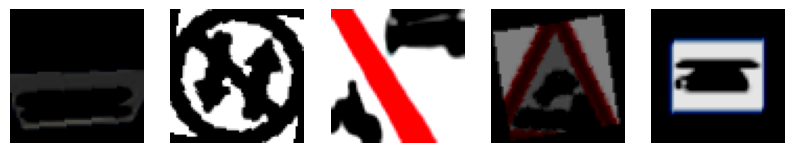

In [4]:
dataset_root = images_path
# 3. Load datasets
traffic_sign_dataset = ImageFolder(root=dataset_root, transform=transform)
gtsrb_dataset = ImageFolder(root=gtsrb_path, transform=transform)

# 4. Get number of classes
num_indian_classes = len(traffic_sign_dataset.classes)
num_gtsrb_classes = len(gtsrb_dataset.classes)

# 5. Remap GTSRB labels to avoid overlap
class RemappedDataset(Dataset):
    def __init__(self, base_dataset, label_offset=0):
        self.base_dataset = base_dataset
        self.label_offset = label_offset

    def __getitem__(self, idx):
        image, label = self.base_dataset[idx]
        return image, label + self.label_offset

    def __len__(self):
        return len(self.base_dataset)

remapped_indian = RemappedDataset(traffic_sign_dataset, label_offset=0)
remapped_gtsrb = RemappedDataset(gtsrb_dataset, label_offset=num_indian_classes)

# 6. Combine both datasets
combined_dataset = ConcatDataset([remapped_indian, remapped_gtsrb])
total_classes = num_indian_classes + num_gtsrb_classes
print("Combined dataset ready with", total_classes, "classes.")

# 7. Optional: Preview samples from Indian dataset
def show_images(loader, num_images=5):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images = images.numpy().transpose((0, 2, 3, 1))
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        axes[i].imshow(np.clip(images[i], 0, 1))
        axes[i].axis('off')
    plt.show()

# Show sample images
sample_loader = DataLoader(traffic_sign_dataset, batch_size=5, shuffle=True)
show_images(sample_loader)


Spliting the data for traing and testing

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch

# Shuffle and split
total_size = len(combined_dataset)
indices = list(range(total_size))

train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_dataset = Subset(combined_dataset, train_indices)
val_dataset = Subset(combined_dataset, val_indices)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=False, generator=torch.Generator().manual_seed(42))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


print(f"✅ Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}")


✅ Train size: 42544, Validation size: 10636


In [6]:
for images, labels in train_loader:
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    break


Images shape: torch.Size([32, 3, 64, 64])
Labels shape: torch.Size([32])


Model training

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class TrafficCNN(nn.Module):
    def __init__(self):
        super(TrafficCNN, self).__init__()

        # Define convolutional layers using Sequential
        self.convs = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 64 -> 32 #updated comment
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # 32 -> 16 #updated comment
        )

        # Calculate flattened size after convs
        self._to_linear = None
        self._get_conv_output()

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, total_classes)

    def _get_conv_output(self):
        with torch.no_grad():
            # Use the correct input size (64x64) to calculate flattened size
            x = torch.randn(1, 3, 64, 64)  # Simulated input with correct size
            x = self.convs(x)
            self._to_linear = x.view(1, -1).size(1)  # Flatten

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Using device: cuda


In [17]:
train_accuracies = []
val_accuracies = []

epochs = 10
for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    # Validation accuracy
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"✅ Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f} - Train Acc: {train_accuracy:.2f}% - Val Acc: {val_accuracy:.2f}%")


✅ Epoch 1/10 - Loss: 0.1605 - Train Acc: 94.51% - Val Acc: 91.84%
✅ Epoch 2/10 - Loss: 0.1535 - Train Acc: 94.69% - Val Acc: 91.94%
✅ Epoch 3/10 - Loss: 0.1487 - Train Acc: 94.96% - Val Acc: 92.53%
✅ Epoch 4/10 - Loss: 0.1485 - Train Acc: 94.96% - Val Acc: 90.98%
✅ Epoch 5/10 - Loss: 0.1302 - Train Acc: 95.64% - Val Acc: 92.78%
✅ Epoch 6/10 - Loss: 0.1335 - Train Acc: 95.36% - Val Acc: 92.22%
✅ Epoch 7/10 - Loss: 0.1331 - Train Acc: 95.54% - Val Acc: 92.42%
✅ Epoch 8/10 - Loss: 0.1262 - Train Acc: 95.72% - Val Acc: 91.37%
✅ Epoch 9/10 - Loss: 0.1238 - Train Acc: 95.92% - Val Acc: 93.34%
✅ Epoch 10/10 - Loss: 0.1280 - Train Acc: 95.80% - Val Acc: 92.53%


In [18]:
def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"✅ Validation Accuracy: {accuracy:.2f}%")

evaluate_model(model, val_loader)


✅ Validation Accuracy: 92.52%


Results and visualizations

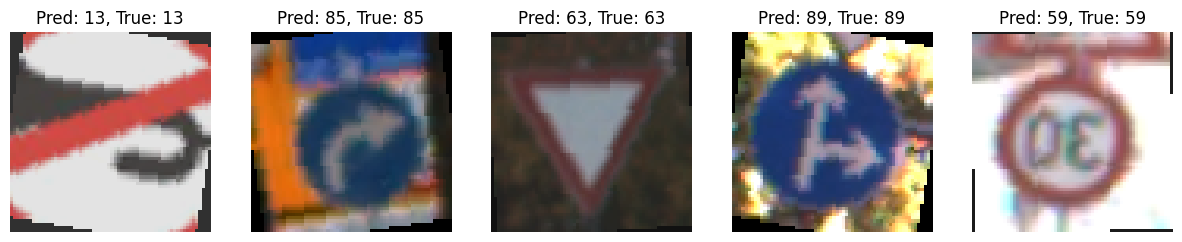

In [19]:
def show_predictions(model, loader, classes, num_images=5):
    model.eval()
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images, labels = images[:num_images], labels[:num_images]

    with torch.no_grad():
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)

    images = images.numpy().transpose((0, 2, 3, 1))
    images = (images * 0.5) + 0.5  # unnormalize

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].set_title(f"Pred: {predicted[i].item()}, True: {labels[i].item()}")
        axes[i].axis('off')
    plt.show()

show_predictions(model, val_loader, classes=None)  # Pass class names if you have them


<Figure size 1000x1000 with 0 Axes>

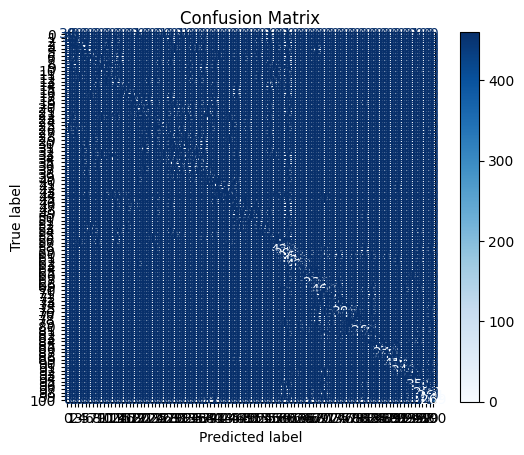

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get all predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Compute and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()


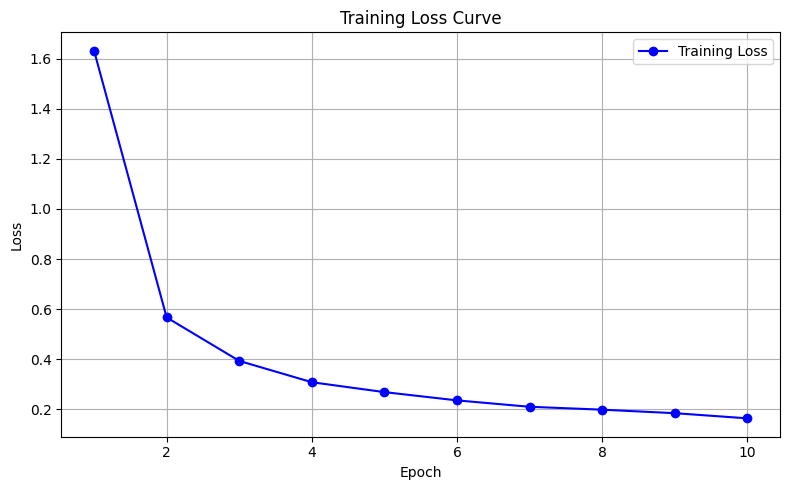

In [15]:
loss_values = [1.6318, 0.5668, 0.3933, 0.3082, 0.2687, 0.2357, 0.2102, 0.1986, 0.1846, 0.1640]
epochs = list(range(1, len(loss_values) + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, loss_values, marker='o', color='blue', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


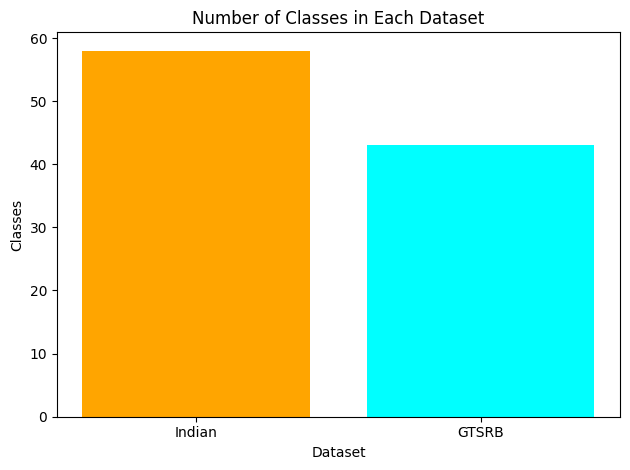

In [16]:
import matplotlib.pyplot as plt

datasets = ['Indian', 'GTSRB']
class_counts = [num_indian_classes, num_gtsrb_classes]

plt.bar(datasets, class_counts, color=['orange', 'cyan'])
plt.title('Number of Classes in Each Dataset')
plt.ylabel('Classes')
plt.xlabel('Dataset')
plt.tight_layout()
plt.show()


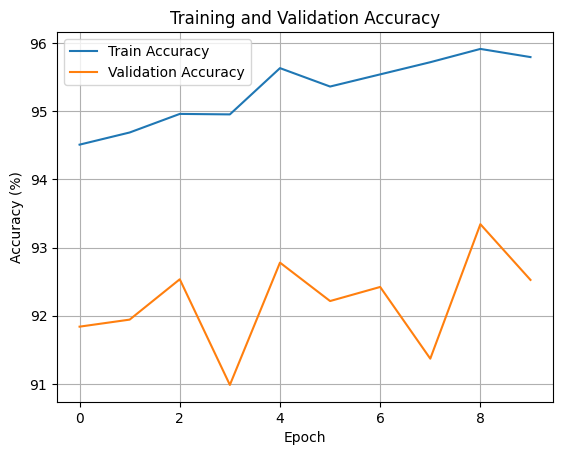

In [20]:
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()
